In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
# current_dir = '/home/jiayuand/seqOED_variational/examples/location'
# parent_dir = '/home/jiayuand/seqOED_variational'

# current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parent_dir = os.path.dirname(os.path.dirname(current_dir))
parent_dir = '/scratch/xhuan_root/xhuan1/wgshen/vsOED/'
sys.path.insert(0, parent_dir) 

import numpy as np
# from scipy.stats import norm, beta, dirichlet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from   torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev) 
torch.set_default_device(device)
dtype = torch.float32
torch.set_default_dtype(dtype)

from vsOED import VSOED, PGvsOED, GMM_NET, NFs, POST_APPROX
from vsOED.utils import *
from vsOED.models import *

import dowel

In [2]:
n_stage      = 10       # Number of stages.
n_design     = 2        # Number of design variables.
n_obs        = 1        # Number of observations.
n_pois       = [2, 4, 6]        # Number of parameters.
n_nuisps     = None
n_goals      = [1, 1, 1]
model_weight = 1
poi_weight   = 1
goal_weight  = 1

random_state  = TRAIN_SEEDS[0]
set_random_seed(random_state)

model = SOURCE(multimodel=True, include_nuisance=False, include_goal=True)
prior = model

mu_bounds = {}
mu_bounds['poi'] = []
for n_poi in n_pois:
    mu_bounds['poi'].append([[-6, 6]] * n_poi)
if n_goals is not None:
    mu_bounds['goal'] = []
    for n_goal in n_goals:
        mu_bounds['goal'].append([[-6, 6]] * n_goal)
max_sigmas = {}
max_sigmas['poi'] = []
for n_poi in n_pois:
    max_sigmas['poi'].append([1.0] * n_poi)
if n_goals is not None:
    max_sigmas['goal'] = []
    for n_goal in n_goals:
        max_sigmas['goal'].append([2.0] * n_goal)
truncnorm_info = {}
truncnorm_info['poi'] = [None] * len(n_pois)
# if n_goals is not None:
#     truncnorm_info['goal'] = []
#     for n_goal in n_goals:
#         info = []
#         for i in range(n_goal):
#             info.append([i, 0, 4])
#         truncnorm_info['goal'].append(info)
truncnorm_info['goal'] = [None] * len(n_goals)
        
            
n_incre = 1
share_interm_net = False

candidate_lrs = [[1e-3] * n_incre, [1e-4] * (n_incre - 1) + [1e-3]]
candidate_gammas = [[0.9999] * n_incre, [0.999999] * (n_incre - 1) + [0.9999]]
model_post_lrs = candidate_lrs[share_interm_net]
model_post_lr_scheduler_gammas = candidate_gammas[share_interm_net]
poi_post_lrs = candidate_lrs[share_interm_net]
poi_post_lr_scheduler_gammas = candidate_gammas[share_interm_net]
goal_post_lrs = candidate_lrs[share_interm_net]
goal_post_lr_scheduler_gammas = candidate_gammas[share_interm_net]

use_NFs = False
n_mixture = 8
activate = nn.ReLU

log_every = 100
folder = parent_dir + f'experiments/source_{len(n_pois)}model_{model_weight}modelw_{poi_weight}poiw_{goal_weight}goalw_{n_stage}stage_{n_incre}incre_GMM/'
try:
    os.remove(folder + 'progress.csv')
except:
    pass
try:
    os.remove(folder + 'progress.txt')
except:
    pass
try:
    dowel.logger.remove_all()
except:
    pass
dowel.logger.add_output(dowel.StdOutput())
dowel.logger.add_output(dowel.CsvOutput(folder + 'progress.csv'))
dowel.logger.add_output(dowel.TextOutput(folder + 'progress.txt'))

try:
    for _ in range(100):
        dowel.logger.pop_prefix()
except:
    pass
dowel.logger.push_prefix('[SOURCE] ')
dowel.logger.log('Stored at ' + folder)
dowel.logger.log('Random seed:  ' + str(random_state))
dowel.logger.log('Device: ' + str(device))
dowel.logger.log('dtype: ' + str(dtype))

post_approx_params = {
    'n_stage': n_stage, 
    'n_design': n_design, 
    'n_obs': n_obs, 
    'n_pois': n_pois,
    'n_nuisps': n_nuisps,
    'n_goals': n_goals,
    'model_weight': model_weight,
    'poi_weight': poi_weight,
    'goal_weight': goal_weight,
    'mu_bounds': mu_bounds,
    'max_sigmas': max_sigmas,
    'truncnorm_info': truncnorm_info,
    'n_mixture': n_mixture,
    'activate': activate,
    'prior': prior,
    'n_incre': n_incre,
    'share_interm_net': share_interm_net,
    'model_post_lrs': model_post_lrs,
    'model_post_lr_scheduler_gammas': model_post_lr_scheduler_gammas,
    'poi_post_lrs': poi_post_lrs,
    'poi_post_lr_scheduler_gammas': poi_post_lr_scheduler_gammas,
    'goal_post_lrs': goal_post_lrs,
    'goal_post_lr_scheduler_gammas': goal_post_lr_scheduler_gammas,
    'use_NFs': use_NFs,
    'log_every': log_every,
    'dowel': dowel}

dowel.logger.log('Post_approx_params: ' + str(post_approx_params))

dowel.logger.dump_all()
# dowel.logger.remove_all()

post_approx = POST_APPROX(**post_approx_params)
dowel.logger.dump_all()

2023-05-01 19:37:45 | [SOURCE] Stored at /scratch/xhuan_root/xhuan1/wgshen/vsOED/experiments/source_3model_1modelw_1poiw_1goalw_10stage_1incre_GMM/
2023-05-01 19:37:45 | [SOURCE] Random seed:  48563549
2023-05-01 19:37:45 | [SOURCE] Device: cuda:0
2023-05-01 19:37:45 | [SOURCE] dtype: torch.float32
2023-05-01 19:37:45 | [SOURCE] Post_approx_params: {'n_stage': 10, 'n_design': 2, 'n_obs': 1, 'n_pois': [2, 4, 6], 'n_nuisps': None, 'n_goals': [1, 1, 1], 'model_weight': 1, 'poi_weight': 1, 'goal_weight': 1, 'mu_bounds': {'poi': [[[-6, 6], [-6, 6]], [[-6, 6], [-6, 6], [-6, 6], [-6, 6]], [[-6, 6], [-6, 6], [-6, 6], [-6, 6], [-6, 6], [-6, 6]]], 'goal': [[[-6, 6]], [[-6, 6]], [[-6, 6]]]}, 'max_sigmas': {'poi': [[1.0, 1.0], [1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]], 'goal': [[2.0], [2.0], [2.0]]}, 'truncnorm_info': {'poi': [None, None, None], 'goal': [None, None, None]}, 'n_mixture': 8, 'activate': <class 'torch.nn.modules.activation.ReLU'>, 'prior': <vsOED.models.SOURCE object at 0

In [3]:
n_param = len(n_pois) > 1
try:
    n_param += max(n_pois)
except:
    pass
try:
    n_param += max(n_nuisps)
except:
    pass
try:
    n_param += max(n_goals)
except:
    pass

design_bounds = [(-4, 4), (-4, 4)] # lower and upper bounds of design variables.
def reward_fun(*args, **kws):
    return 0
nkld_reward_fun = model.reward_fun
kld_reward_fun = post_approx.reward_fun
phys_state_info = None
post_approx = post_approx
encoder_dimns = None
backend_dimns = None
actor_dimns = [256, 256, 256]
critic_dimns = [256, 256, 256]

vsoed_params = {
    'n_stage': n_stage,
    'n_param': n_param,
    'n_design': n_design,
    'n_obs': n_obs,
    'model': model,
    'prior': prior,
    'design_bounds': design_bounds,
    'nkld_reward_fun': nkld_reward_fun,
    'kld_reward_fun': kld_reward_fun,
    'phys_state_info': phys_state_info,
    'post_approx': post_approx,
    'encoder_dimns': encoder_dimns,
    'backend_dimns': backend_dimns,
    'actor_dimns': actor_dimns,
    'critic_dimns': critic_dimns,
    'activate': activate
}
dowel.logger.log('vsoed_params: ' + str(vsoed_params))

vsoed = PGvsOED(**vsoed_params)

2023-05-01 19:37:47 | [SOURCE] vsoed_params: {'n_stage': 10, 'n_param': 8, 'n_design': 2, 'n_obs': 1, 'model': <vsOED.models.SOURCE object at 0x1537d1a77730>, 'prior': <vsOED.models.SOURCE object at 0x1537d1a77730>, 'design_bounds': [(-4, 4), (-4, 4)], 'nkld_reward_fun': <bound method SOURCE.reward_fun of <vsOED.models.SOURCE object at 0x1537d1a77730>>, 'kld_reward_fun': <bound method POST_APPROX.reward_fun of <vsOED.post_approx.POST_APPROX object at 0x1537cc0a3a60>>, 'phys_state_info': None, 'post_approx': <vsOED.post_approx.POST_APPROX object at 0x1537cc0a3a60>, 'encoder_dimns': None, 'backend_dimns': None, 'actor_dimns': [256, 256, 256], 'critic_dimns': [256, 256, 256], 'activate': <class 'torch.nn.modules.activation.ReLU'>}


In [4]:
actor_lr = 1e-3
actor_lr_scheduler_gamma = 0.9999
critic_lr = 1e-3
critic_lr_scheduler_gamma = 0.9999
    
n_update = 10001
n_newtraj = 1000
n_batch = 10000
n_buffer_init = n_batch * 2
n_buffer_max = int(1e6)
buffer_device = torch.device('cuda')
discount = 1 if n_incre == 1 else 0.9
encoder_actor_optimizer = None
encoder_actor_lr_scheduler = None
encoder_critic_optimizer = None
encoder_critic_lr_scheduler = None
actor_optimizer = optim.Adam(vsoed.actor_net.parameters(), lr=actor_lr)
actor_lr_scheduler = optim.lr_scheduler.ExponentialLR(actor_optimizer, gamma=actor_lr_scheduler_gamma)
n_critic_update = 5
critic_optimizer = optim.Adam(vsoed.critic_net.parameters(), lr=critic_lr)
critic_lr_scheduler = optim.lr_scheduler.ExponentialLR(critic_optimizer, gamma=critic_lr_scheduler_gamma)
n_post_approx_update = 5
lr_target = 0.1
design_noise_scale = 0.5
design_noise_decay = 0.9999
on_policy = False
use_PCE = False
use_PCE_incre = None
n_contrastive_sample = None
transition = 10000 if n_incre == 1 else 0
frozen = -1
log_every = 100
save_every = 1000
save_path = folder
restart = False

vsoed_train_params = {
    'n_update': n_update,
    'n_newtraj': n_newtraj,
    'n_batch': n_batch,
    'n_buffer_init': n_buffer_init,
    'n_buffer_max': n_buffer_max,
    'buffer_device': buffer_device,
    'discount': discount,
    'encoder_actor_optimizer': encoder_actor_optimizer,
    'encoder_actor_lr_scheduler': encoder_actor_lr_scheduler,
    'encoder_critic_optimizer': encoder_critic_optimizer,
    'encoder_critic_lr_scheduler': encoder_critic_lr_scheduler,
    'actor_lr': actor_lr,
    'actor_optimizer': actor_optimizer,
    'actor_lr_scheduler_gamma': actor_lr_scheduler_gamma, 
    'actor_lr_scheduler': actor_lr_scheduler,
    'n_critic_update': n_critic_update,
    'critic_lr': critic_lr,
    'critic_optimizer': critic_optimizer,
    'critic_lr_scheduler_gamma': critic_lr_scheduler_gamma,
    'critic_lr_scheduler': critic_lr_scheduler,
    'n_post_approx_update': n_post_approx_update,
    'lr_target': lr_target,
    'design_noise_scale': design_noise_scale,
    'design_noise_decay': design_noise_decay,
    'on_policy': on_policy,
    'use_PCE': use_PCE,
    'use_PCE_incre': use_PCE_incre,
    'n_contrastive_sample': n_contrastive_sample,
    'transition': transition,
    'frozen': frozen,
    'log_every': log_every,
    'dowel': dowel,
    'save_every': save_every,
    'save_path': save_path,
    'restart': restart
}

dowel.logger.log('vsoed_train_params: ' + str(vsoed_train_params))

del vsoed_train_params['actor_lr']
del vsoed_train_params['actor_lr_scheduler_gamma']
del vsoed_train_params['critic_lr']
del vsoed_train_params['critic_lr_scheduler_gamma']

2023-05-01 19:37:47 | [SOURCE] vsoed_train_params: {'n_update': 10001, 'n_newtraj': 1000, 'n_batch': 10000, 'n_buffer_init': 20000, 'n_buffer_max': 1000000, 'buffer_device': device(type='cuda'), 'discount': 1, 'encoder_actor_optimizer': None, 'encoder_actor_lr_scheduler': None, 'encoder_critic_optimizer': None, 'encoder_critic_lr_scheduler': None, 'actor_lr': 0.001, 'actor_optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
), 'actor_lr_scheduler_gamma': 0.9999, 'actor_lr_scheduler': <torch.optim.lr_scheduler.ExponentialLR object at 0x1537cc05acd0>, 'n_critic_update': 5, 'critic_lr': 0.001, 'critic_optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 

In [5]:
try:
    for _ in range(100):
        dowel.logger.pop_prefix()
except:
    pass
dowel.logger.push_prefix('[SOURCE] ')
vsoed.train(**vsoed_train_params)

2023-05-01 19:37:48 | [SOURCE] epoch #0 | log model post after training: -1.0005024671554565
2023-05-01 19:37:48 | [SOURCE] epoch #0 | log param_of_interest post after training: -6.9185285568237305
2023-05-01 19:37:48 | [SOURCE] epoch #0 | log goal post after training: -1.4836208820343018
2023-05-01 19:37:49 | [SOURCE] epoch #0 | Checkpoint saved
2023-05-01 19:37:49 | [SOURCE] epoch #0 | Total time 1.14 s
2023-05-01 19:37:49 | [SOURCE] epoch #0 | Epoch time 0.64 s
------------------------  --------------------------------------------
Design/MeanDesign         [-0.11794450134038925, 0.15428344905376434]
Design/StdDesign          [0.027206582948565483, 0.024982020258903503]
Epoch                     0
ReplayBuffer/buffer_size  20000
Reward/MeanReward         -5.675124645233154
Reward/StdReward          4.103697299957275
------------------------  --------------------------------------------


/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Epoch: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Reward/MeanReward: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Reward/StdReward: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Design/MeanDesign: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInputWarning: TabularInput {Design/StdDesign: type(str)} was not accepted by any output
  self.dowel.tabular.clear()
/scratch/xhuan_root/xhuan1/wgshen/vsOED/vsOED/pg_vsoed.py:721: TabularInpu

2023-05-01 19:38:24 | [SOURCE] epoch #100 | log model post after training: -0.7697068452835083
2023-05-01 19:38:24 | [SOURCE] epoch #100 | log param_of_interest post after training: -4.511432647705078
2023-05-01 19:38:24 | [SOURCE] epoch #100 | log goal post after training: 0.2712583839893341
2023-05-01 19:38:24 | [SOURCE] epoch #100 | Total time 36.68 s
2023-05-01 19:38:24 | [SOURCE] epoch #100 | Epoch time 0.36 s
------------------------  -------------------------------------------
Design/MeanDesign         [-0.43711093068122864, 0.10172319412231445]
Design/StdDesign          [0.7583106756210327, 0.49107009172439575]
Epoch                     100
ReplayBuffer/buffer_size  120000
Reward/MeanReward         1.6130839586257935
Reward/StdReward          1.9889745712280273
------------------------  -------------------------------------------
2023-05-01 19:38:59 | [SOURCE] epoch #200 | log model post after training: -0.6617699265480042
2023-05-01 19:38:59 | [SOURCE] epoch #200 | log param_o

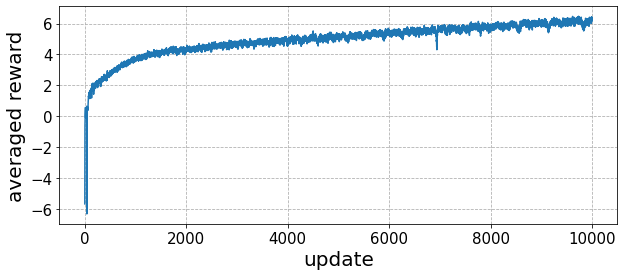

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(vsoed.update_hist[:])
plt.xlabel('update', fontsize=20)
plt.ylabel('averaged reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(linestyle='--')

In [15]:
set_random_seed(EVAL_SEEDS[0])
ret = vsoed.asses(2000, n_contrastive_sample=int(1e6), return_all=True)
averaged_reward = ret['averaged_reward']
params = ret['params']
ds_hist = ret['ds_hist']
ys_hist = ret['ys_hist']
rewards_hist = ret['rewards_hist']
averaged_reward

100%|██████████| 2000/2000 [00:26<00:00, 76.52it/s]


6.285343170166016

In [18]:
set_random_seed(EVAL_SEEDS[0])
ret = vsoed.asses(int(1e6), use_PCE=False, use_PCE_incre=False, return_all=True)
averaged_reward = ret['averaged_reward']
params = ret['params']
ds_hist = ret['ds_hist']
ys_hist = ret['ys_hist']
rewards_hist = ret['rewards_hist']
averaged_reward

6.718046188354492

In [9]:
m_true = params[:, 0].to(int)
logevid = post_approx.log_model_post(None, ds_hist, ys_hist)
evid_pred = torch.exp(logevid).cpu().detach().numpy()

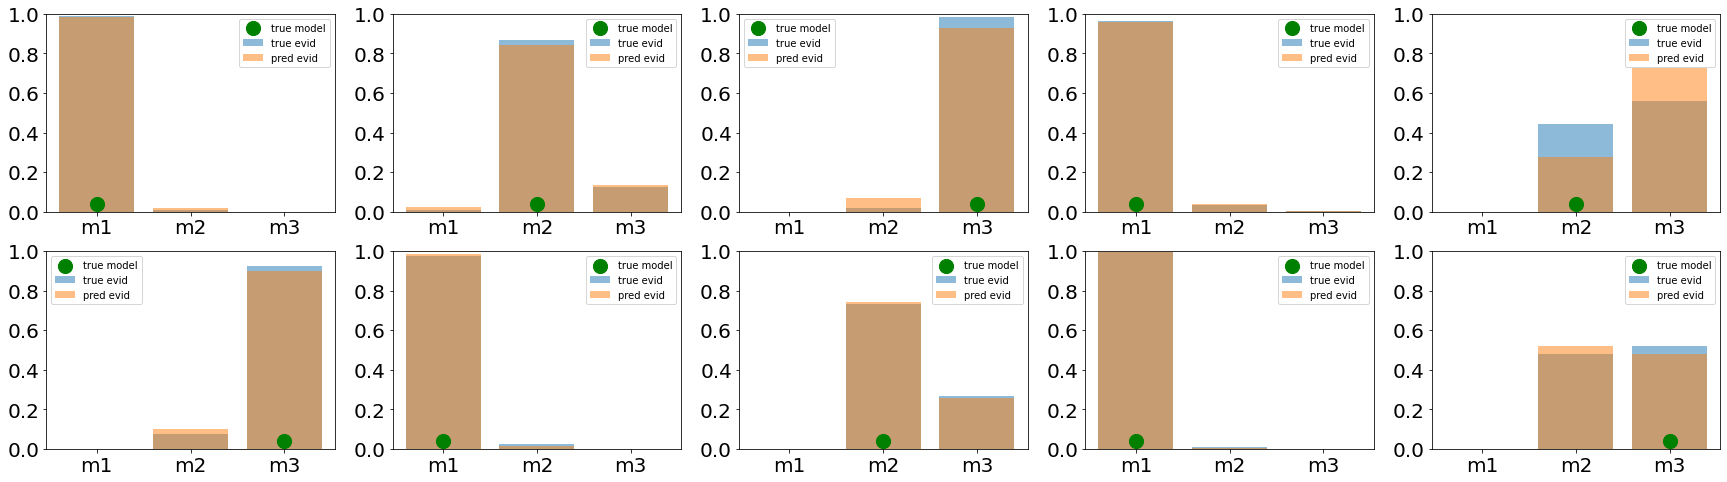

In [12]:
np.random.seed(548)
idxs = np.random.choice(len(ds_hist), 10, replace=False)
plt.figure(figsize=(30, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1)
    loglikelis = 0
    for stage in range(n_stage):
        loglikelis += model.loglikeli(stage, ys_hist[idx:idx+1, stage, :], params, ds_hist[idx:idx+1, stage, :])
    likelis = torch.exp(loglikelis)
    evids_true = []
    for m_idx in range(len(n_pois)):
        evids_true.append(likelis[m_idx == m_true].mean().item())
    evids_true = np.array(evids_true)
    evids_true /= evids_true.sum()
    # print('evids_true: ', evids_true)
    # print('evids_pred: ', evid_pred[idx])
    plt.bar(['m1', 'm2', 'm3'], evids_true, alpha=0.5, label='true evid')
    plt.bar(['m1', 'm2', 'm3'], evid_pred[idx], alpha=0.5, label='pred evid')
    plt.scatter(m_true[idx].cpu().numpy(), 0.04, s=200, zorder=10, c='green', label='true model')
    # plt.yscale('log')
    plt.ylim(0, 1)
    plt.legend(fontsize=10)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
plt.show()

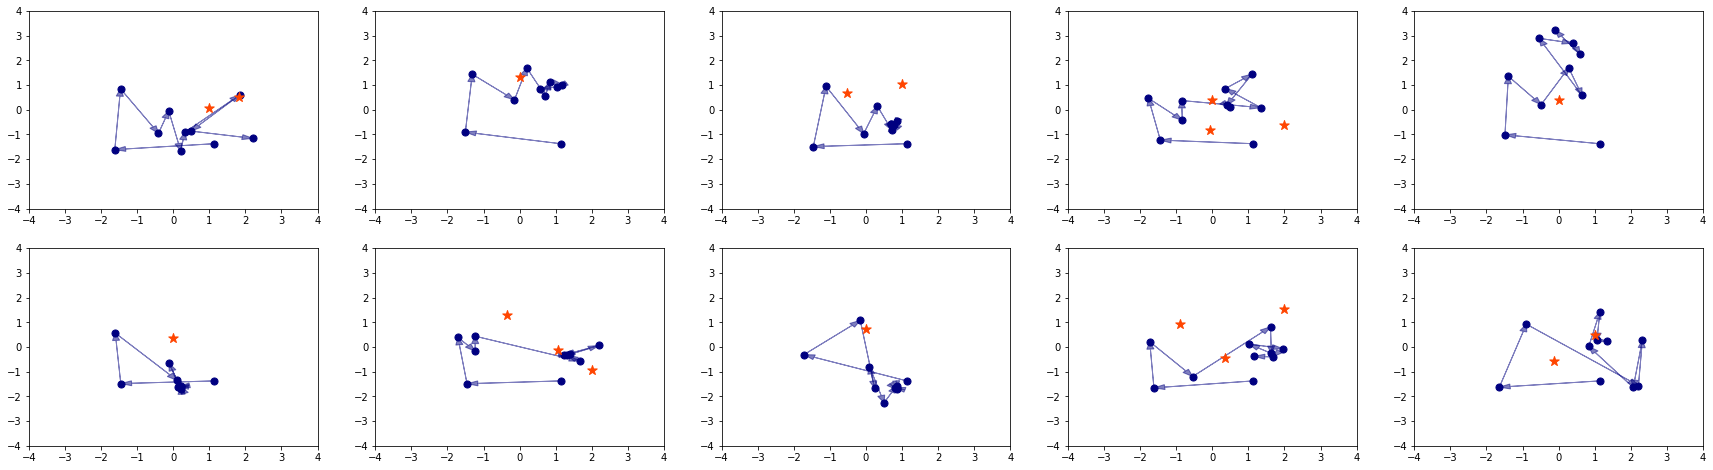

In [11]:
idxs = np.random.choice(len(ds_hist), 10, replace=False)
plt.figure(figsize=(30, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1)
    theta = params[idx].cpu().numpy()
    d_hist = ds_hist[idx].cpu().numpy()
    y_hist = ys_hist[idx].cpu().numpy()
    for i in range(int(theta[0]) + 1):
        plt.scatter(theta[i*2], theta[i*2+1], c='orangered', s=100, marker='*', zorder=10)
    d_old = None
    for d in d_hist:
        plt.scatter(d[0], d[1], c='navy', s=50)
        if d_old is not None:
            plt.arrow(d_old[0], d_old[1], d[0] - d_old[0], d[1] - d_old[1], alpha=0.5, color='navy', head_width=0.2, length_includes_head=True)
        d_old = d
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)

In [20]:
from tqdm import tqdm
np.random.seed(548)
idxs = torch.from_numpy(np.random.choice(len(params), 100, replace=False)).to(device)
evid_klds = []
for idx in tqdm(idxs):
    loglikelis = 0
    for stage in range(n_stage):
        loglikelis += model.loglikeli(stage, ys_hist[idx:idx+1, stage, :], params, ds_hist[idx:idx+1, stage, :])
    likelis = torch.exp(loglikelis)
    evids_true = []
    for m_idx in range(len(n_pois)):
        evids_true.append(likelis[m_idx == m_true].mean().item())
    evids_true = np.array(evids_true)
    evids_true /= evids_true.sum()
    evid_klds.append((evids_true * np.log(evids_true * 3)).sum())
evid_klds = np.array(evid_klds)
print('evid kld: ', evid_klds.mean())

100%|██████████| 100/100 [00:01<00:00, 81.15it/s]

evid kld:  0.6345600564901903


In [23]:
ds_hist[30]

tensor([[-0.7289,  0.6698],
        [ 0.8817,  1.2228],
        [ 1.4341,  0.6463],
        [ 1.0733, -1.2968],
        [-0.8485, -0.9864],
        [ 0.3985,  0.4226],
        [ 0.2888, -0.5700],
        [ 0.0655, -0.3715],
        [-0.0392, -0.7437],
        [ 0.2918, -0.7857]], device='cuda:0')

In [25]:
rewards_hist[:, :5].sum(-1).mean()

tensor(3.6108, device='cuda:0')

In [35]:
p_max = torch.arange(1, vsoed.n_buffer_max + 1).to(torch.float32)
l_buffer = 1000000
p = p_max[:l_buffer]
p /= p.sum()
idxs_pick = torch.multinomial(p, vsoed.n_batch, replacement=False)

(array([ 112.,  307.,  480.,  745.,  934., 1096., 1278., 1487., 1672.,
        1889.]),
 array([ 10025. , 109021.9, 208018.8, 307015.7, 406012.6, 505009.5,
        604006.4, 703003.3, 802000.2, 900997.1, 999994. ]),
 <BarContainer object of 10 artists>)

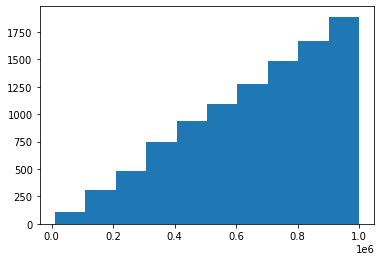

In [36]:
plt.hist(idxs_pick.cpu().numpy())

In [6]:
import joblib

In [7]:
joblib.dump(vsoed, folder + 'itr_0.pkl')

TypeError: cannot pickle 'module' object

In [9]:
vsoed.nkld_rw_f

<function vsOED.vsoed.VSOED.__init__.<locals>.nkld_rw_f(*args, **kws)>

In [51]:
torch.tensor(())

tensor([])

In [36]:
{'a': 1}.update({'b': 5})

In [10]:
np.random.choice(int(1e10), 10)

array([6377791278, 7037998855, 7556092991, 8217385358, 8695645867,
       1645853955, 1283211782, 8616980401, 3169416485, 1613878827])

In [ ]:
dict().update